In [1]:
# 基本的なパッケージ
import numpy as np # 線形代数
import pandas as pd # データの加工, CSVファイルのI/O (e.g. pd.read_csv)
import random as rd # 乱数の生成
import datetime # manipulating date formats
# 可視化用
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# 時系列解析用
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# 設定
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv(r"C:\Users\xuhan\Desktop\我的坚果云\Sys_learning\7_\competitive-data-science-predict-future-sales\sales_train.csv"
                  )
item_cat=pd.read_csv(r"C:\Users\xuhan\Desktop\我的坚果云\Sys_learning\7_\competitive-data-science-predict-future-sales\item_categories.csv")
item=pd.read_csv(r"C:\Users\xuhan\Desktop\我的坚果云\Sys_learning\7_\competitive-data-science-predict-future-sales\items.csv")
sub=pd.read_csv(r"C:\Users\xuhan\Desktop\我的坚果云\Sys_learning\7_\competitive-data-science-predict-future-sales\sample_submission.csv")
shops=pd.read_csv(r"C:\Users\xuhan\Desktop\我的坚果云\Sys_learning\7_\competitive-data-science-predict-future-sales\shops.csv")
test=pd.read_csv(r"C:\Users\xuhan\Desktop\我的坚果云\Sys_learning\7_\competitive-data-science-predict-future-sales\test.csv")

In [3]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
df_tmp = data.copy()
df_tmp.reset_index(inplace=True)#单独添加一行序号，而不是把report_date作为序号
df_tmp['date'] = pd.to_datetime(df_tmp['date']
                               # , format='%Y%m%d'
                               )#把时间变成月日年格
df_tmp.index = df_tmp['date']
df_tmp.drop('index',axis = 1, inplace = True)
#df_tmp.drop('date',axis = 1, inplace = True)
df_tmp.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,,
2013-02-01,2013-02-01,0,59,22154,999.00,1.0
2013-03-01,2013-03-01,0,25,2552,899.00,1.0
2013-05-01,2013-05-01,0,25,2552,899.00,-1.0
2013-06-01,2013-06-01,0,25,2554,1709.05,1.0
2013-01-15,2013-01-15,0,25,2555,1099.00,1.0


In [5]:
monthly_sales=df_tmp.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg(
    {"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [6]:
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-21 2013-03-01      221.0          6.0
                       33      2013-01-17 2013-03-01      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-10-01 2013-10-01      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-06-01 2013-06-01      193.0          1.0
                       96      2013-10-01 2013-10-01       70.0          1.0
                       98      2013-01-13 2013-12-01      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-17 2013-11-01       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-09-01 2013-09-01      258.0          1.0
                       198     2013-10-01 2013-10-01      112.0          1.0
                       210     2013-01-25 2013-05-01      118.0          2.0
                       282     2013-04-01 2013-04-01      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [7]:
#每个类别的项目数
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


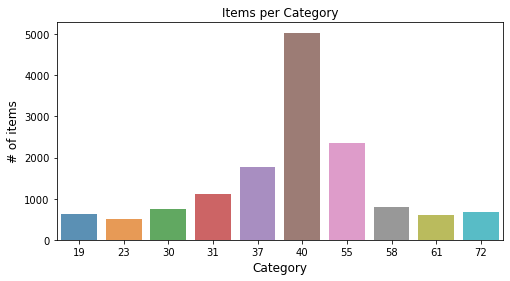

In [8]:
# plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [9]:
#预测整个公司的每月总销售额
ts=df_tmp.groupby(["date_block_num"])["item_cnt_day"].sum()#date_block_num就是月份
ts.astype('float')

date_block_num
0     131479.0
1     128090.0
2     147142.0
3     107190.0
4     106970.0
5     125381.0
6     116966.0
7     125291.0
8     133332.0
9     127541.0
10    130009.0
11    183342.0
12    116899.0
13    109687.0
14    115297.0
15     96556.0
16     97790.0
17     97429.0
18     91280.0
19    102721.0
20     99208.0
21    107422.0
22    117845.0
23    168755.0
24    110971.0
25     84198.0
26     82014.0
27     77827.0
28     72295.0
29     64114.0
30     63187.0
31     66079.0
32     72843.0
33     71056.0
Name: item_cnt_day, dtype: float64

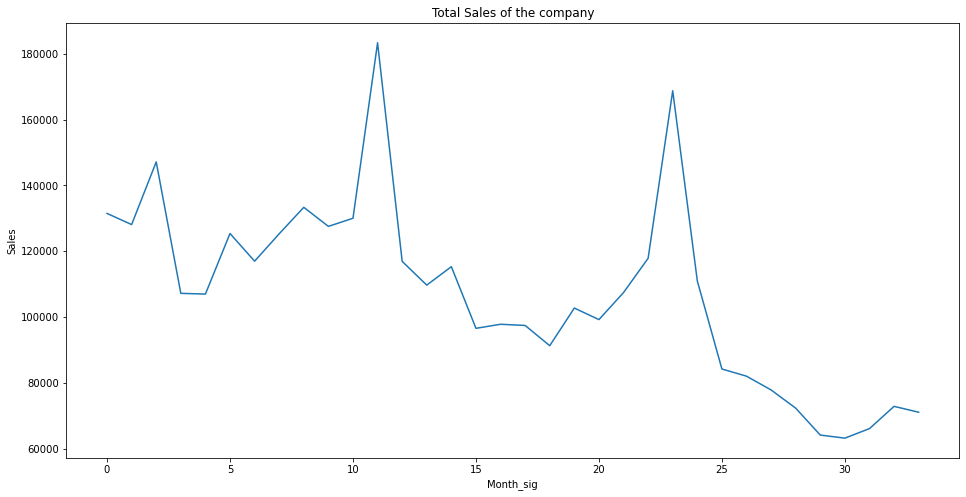

In [10]:
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Month_sig')
plt.ylabel('Sales')
plt.plot(ts)

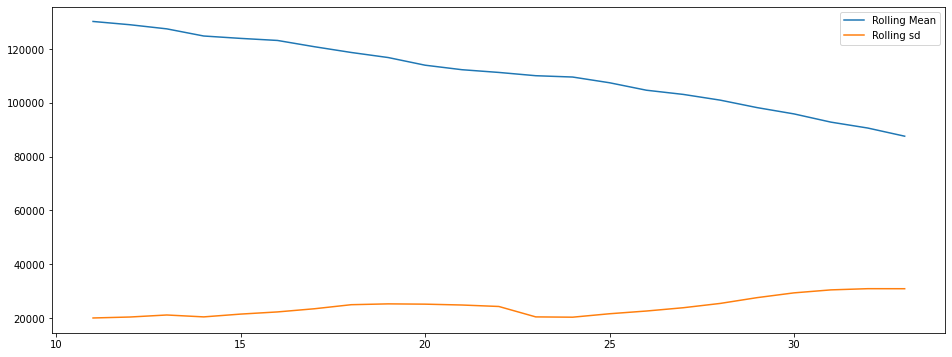

In [11]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
#pandas移动窗口，每12取一个平均值或标准差
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

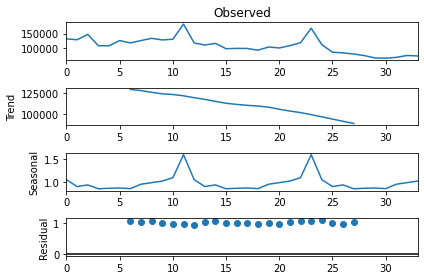

In [12]:
import statsmodels.api as sm
# 乘法模型
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

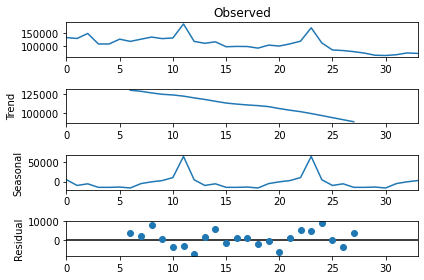

In [13]:
# 加法模型
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [14]:
#检验是不是稳态时间序列模型
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [15]:
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

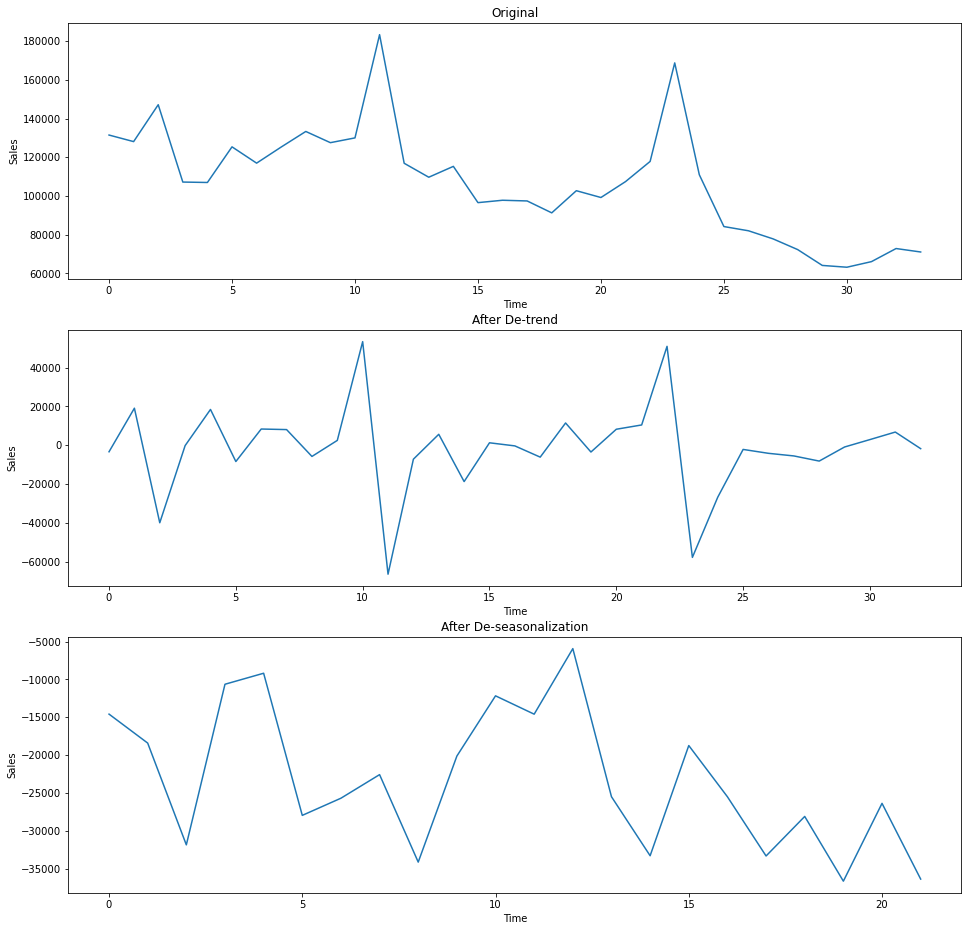

In [16]:
ts=df_tmp.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')

new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # 季節性は12か月とおく
plt.plot(new_ts)
plt.plot()

In [17]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [18]:
#转换后，DF检验的p值在5%以内。 因此，我们可以假设该系列的静止性。
#通过使用我们之前定义的反变换函数，我们可以很容易地恢复到原始系列。
#MA--系列中的下一个值是前n个值的平均值的函数
#AR--下一个值的误差（平均值之间的差异）是前n个值的误差的函数 
#ARMA--两者的混合物


In [19]:
# aicで最適な順番を選ぶ 
# 最小のaic値が勝つ
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [20]:
#将一个日期作为索引添加到时间序列中
ts=df_tmp.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [21]:
from fbprophet import Prophet
# prophetは以下の設定でpandas dfを必要とします。
# ( date column named as DS and the value column as Y)

In [22]:
'''
ts.columns=['ds','y']
model = Prophet(yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly
model.fit(ts) #fit the model with your datafram
'''

"\nts.columns=['ds','y']\nmodel = Prophet(yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly\nmodel.fit(ts) #fit the model with your datafram\n"

In [23]:
'''
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
'''

NameError: name 'model' is not defined

In [25]:
total_sales=df_tmp.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [31]:
# 月次の販売データからアイテム・ストアのユニークな組み合わせを取得する
monthly_sales=df_tmp.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start ='2013-01-01',end='2015-10-01'
                    , freq = 'MS'
                   )
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [ ]:
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    nodeToForecast.columns=['ds','y']
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KeyError: 'metric_file'